In [320]:
import numpy as np
from os.path import dirname, join as pjoin
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.signal import find_peaksß
from scipy import interpolate
from lmfit.models import LorentzianModel, ConstantModel
from lmfit import Model
%matplotlib notebook
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [18]:
PLEnum = 43375
filename = 'PLtlb1piezoitr_' + str(PLEnum)+'.mat'
data_dir = pjoin('/Users/zihuaiz/Desktop/zihuaiz/Python/Data Processing/PLE_utils', filename)
mat_contents = sio.loadmat(data_dir)

In [358]:
def trunc(values, decs=0):
        return np.trunc(values*10**decs)/(10**decs)

def PLEproc(filenum,PLEdir,threshold = 0.005,title = '',cleanindex = 5):

    PLEnum = int(filenum)
    filename = 'PLtlb1piezoitr_' + str(PLEnum)+'.mat'
    data_dir = pjoin(PLEdir, filename)
    mat_contents = sio.loadmat(data_dir)
    fig, ax = plt.subplots(3,2,figsize = (6,4),constrained_layout=True)
    X = mat_contents['xvals'][0]
    Y = mat_contents['yvals'][0]
    Y = np.linspace(1,len(Y),len(Y))
    Z = mat_contents['pl'].transpose()
    REF = mat_contents['ref'].transpose()
    ax[0,0].pcolormesh(X,Y,Z,shading = 'auto',cmap=cm.inferno)
    ax[0,0].set_yticks(Y)
    ax[1,0].pcolormesh(X,Y,mat_contents['ref'].transpose(),shading = 'auto',cmap=cm.inferno)
    ax[1,0].set_yticks(Y)
    xx = mat_contents['xvals'][0]
    ref = -mat_contents['ref'].transpose()[0,cleanindex:]
    peaks, _ = find_peaks(ref,height = threshold,distance = 3)
    rolled = peaks - np.roll(peaks,1)
    distance = np.mean(rolled[1:-1])/2
    peaks, _ = find_peaks(ref,height = threshold,distance = distance)
    ax[2,0].plot(xx[peaks+cleanindex],ref[peaks],'x',markersize = 4)
    ax[2,0].plot(xx[cleanindex:],ref)
    PLEadjust = np.zeros((len(X),len(Y)))
    REFadjust = np.zeros((len(X),len(Y)))
    for i in range(len(mat_contents['yvals'][0])):
        xx = mat_contents['xvals'][0]
        ref = -mat_contents['ref'].transpose()[i,cleanindex:]
        peaks, _ = find_peaks(ref,height = threshold,distance = distance)
        peaks = peaks + cleanindex
        loc = np.ones(len(peaks))*(i+1)
        ax[1,0].plot(xx[peaks],loc,'bo',markersize=3)
        #ax[0,1].plot(xx[peaks])
        peaksI = np.linspace(0,1.5*(len(peaks)-1),len(peaks))
        if i ==0:
            f = interpolate.interp1d(xx[peaks],peaksI,kind = 'linear',fill_value='extrapolate')
            freq = f(xx) 
            PLEadjust[:,i] = Z[i,:]
            REFadjust[:,i] = REF[i,:]
        else:
            fTemp = interpolate.interp1d(xx[peaks],peaksI,kind = 'linear',fill_value='extrapolate')
            freqTemp = fTemp(xx)
            PLEf = interpolate.interp1d(freqTemp,Z[i,:],kind = 'linear',fill_value='extrapolate')
            PLEadjust[:,i] = PLEf(freq)
            REFf = interpolate.interp1d(freqTemp,REF[i,:],kind = 'linear',fill_value='extrapolate')
            REFadjust[:,i] = REFf(freq)
    ax[0,1].pcolormesh(freq,Y, PLEadjust.transpose(),shading = 'auto',cmap=cm.inferno)
    ax[1,1].pcolormesh(freq,Y, REFadjust.transpose(),shading = 'auto',cmap=cm.inferno)
    
    PLEaverage = np.mean(PLEadjust,axis = 1)
    ax[2,1].plot(freq,PLEaverage)

    peak = LorentzianModel()
    pars = peak.guess(PLEaverage, x=freq)
    background = ConstantModel()
    pars.update(background.make_params())
    model = peak + background
    #pars = model.guess(PLEaverage, x=freq)
    out = model.fit(PLEaverage,pars, x=freq)
    FWHM = out.params['fwhm'].value
    Error = out.params['fwhm'].stderr
    FWHMlabel = trunc(out.params['fwhm'].value,decs =3)
    Errorlabel = trunc(out.params['fwhm'].stderr,decs = 3)
    ax[2,1].plot(freq,out.best_fit,label = 'FWHM: ' + str(FWHMlabel) + '(' + str(Errorlabel)+')'' GHz' )
    #ax[2,1].legend(frameon = False)
    ax[0,1].set_title('PLE ' + str(PLEnum) +  ', ' + str(FWHMlabel) + '(' + str(Errorlabel)+')'' GHz' + ' ' +title)
    ax[0,0].set_title('PLE ' + str(PLEnum) +  ' Raw')
    #fig.delaxes(ax[2][0])
    #fig.tight_layout()
    return freq, PLEaverage, out.best_fit,FWHM, Error

def PLEsat(x,Gamma0,P0):
    return Gamma0*np.sqrt(1+x/P0)

def PLEprocBatch(filenumarray,PLEdir,VOA,wavelength = 950,options = 1):
    # options = 1, power vs linewidth
    # options = 2, power vs intensity
    # params is power array
    VOAdir = '/Volumes/homes/deleonlab/data/SiV/2020-12-22 PLE on MT'
    filename = 'PM_VOAcal_' + str(round(wavelength))+'.0nm.mat'
    data_dir = pjoin(VOAdir, filename)
    VOA_contents = sio.loadmat(data_dir)
    Voltage = VOA_contents['voltage'][0]
    Power = VOA_contents['power'][0][-200:]
    PowerCal = np.interp(VOA,Voltage,Power)
    FWHM = np.zeros(len(filenumarray))
    Error = np.zeros(len(filenumarray))
    fig, ax = plt.subplots(1,2,figsize = (6,2),constrained_layout=True)
    for i in range(len(filenumarray)):
        freq,PLEaverage,bestFit, FWHM[i], Error[i] = PLEproc(filenumarray[i],PLEdir,threshold = 0.005,title = '')
        ax[0].plot(freq,PLEaverage)
        ax[0].plot(freq,bestFit)
    satmodel = Model(PLEsat)
    satmodel.set_param_hint('Gamma0', value=0.2,min = 0.01,max = 1)
    satmodel.set_param_hint('P0', value=0.01, min=0.001, max=1)
    params = satmodel.make_params(Gamma0 = 0.1, P0 = 0.01)
    out = satmodel.fit(FWHM,params, x=PowerCal)
    ax[1].errorbar(PowerCal,FWHM,Error)
    Gamma0 = trunc(out.params['Gamma0'].value,3)
    P0 = trunc(out.params['P0'].value,3)
    ax[1].plot(PowerCal,out.best_fit,label = 'G0: ' + str(Gamma0) + '(GHz)' + ' P0: ' + str(P0) + '(mW)' )
    ax[1].legend(frameon = False)
    ax[1].set_xlabel('Power in fiber (mW)')
    ax[1].set_ylabel('FWHM (GHz)')
    ax[0].set_xlabel('Frequency (GHz)')
    ax[0].set_ylabel('Intensity (cps)')

In [309]:
yy

array([0.58819758, 0.3033027 , 0.1375207 , 0.05193508, 0.01670055,
       0.00464521, 0.00102694])

<IPython.core.display.Javascript object>


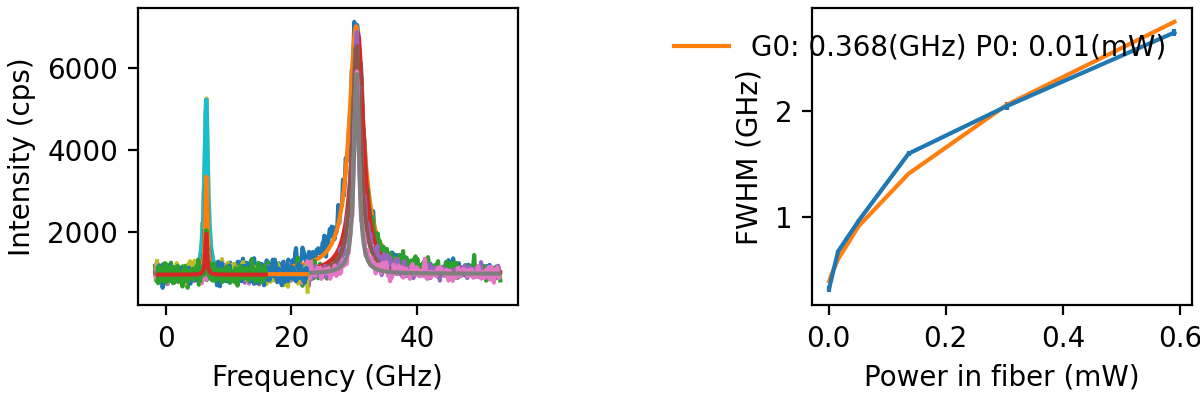

<IPython.core.display.Javascript object>


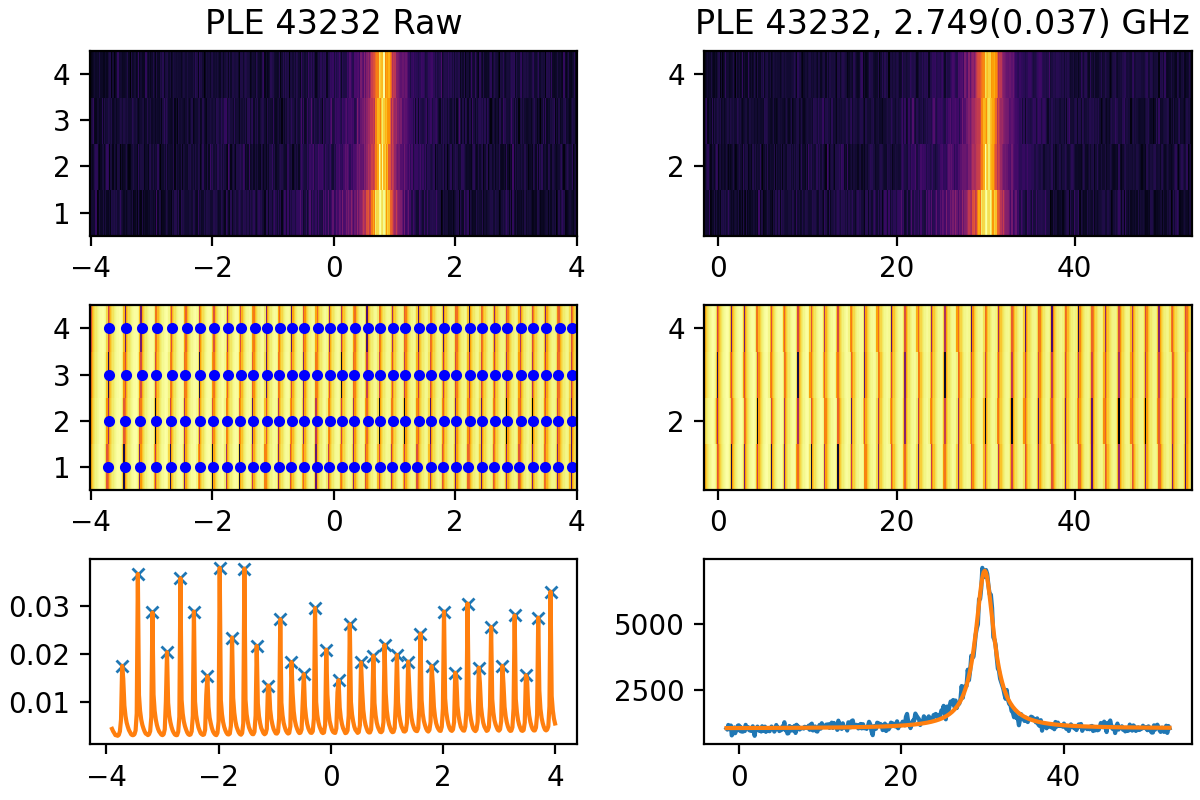

<IPython.core.display.Javascript object>


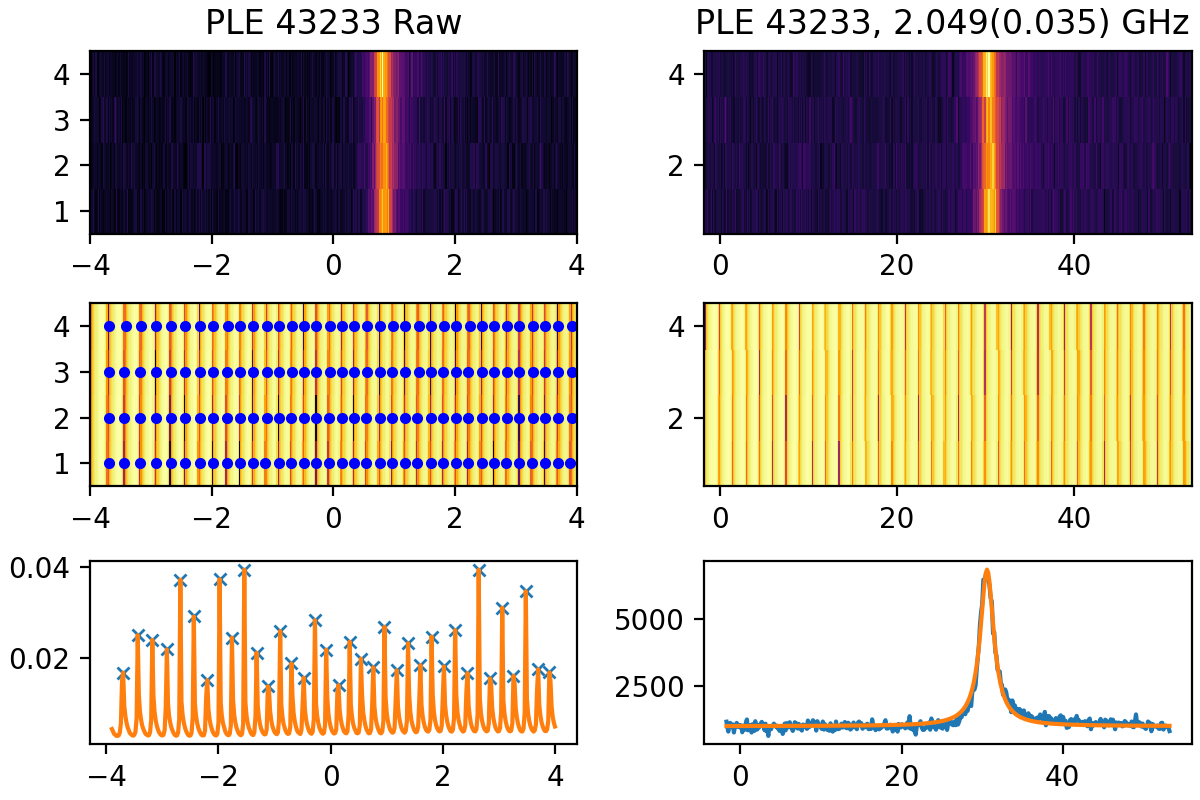

<IPython.core.display.Javascript object>


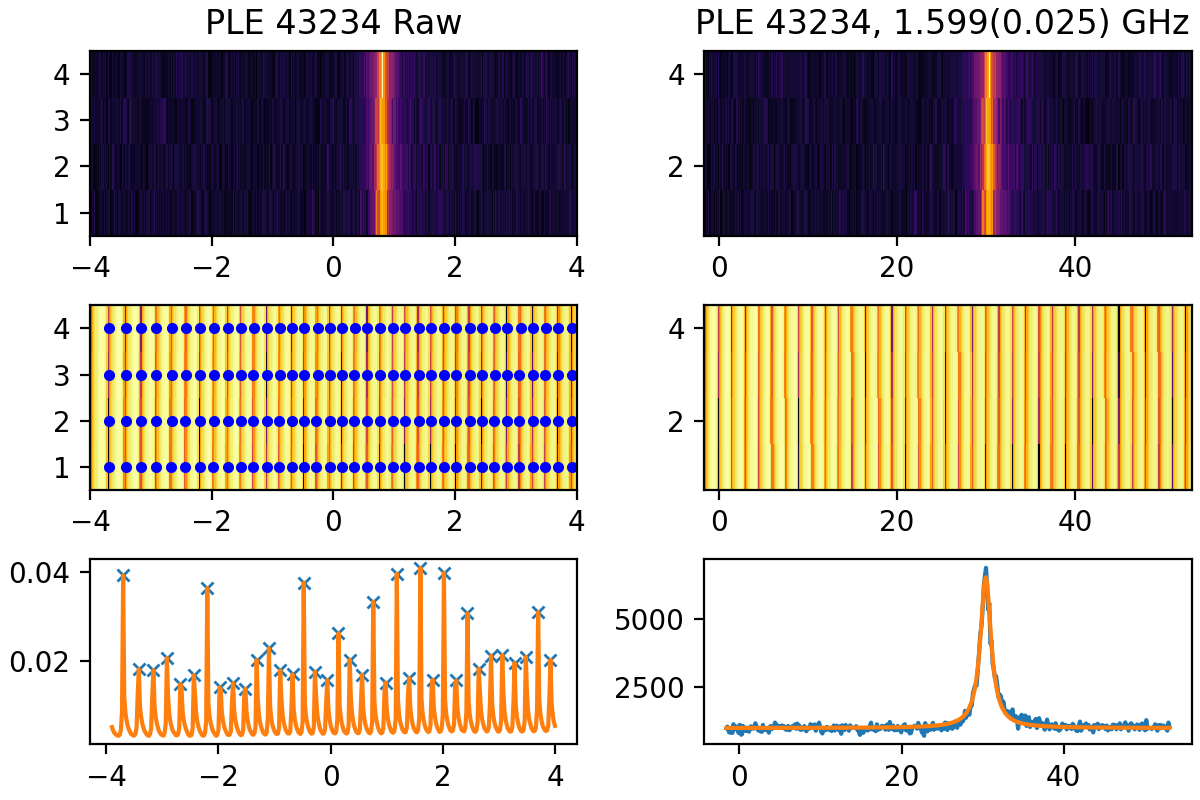

<IPython.core.display.Javascript object>


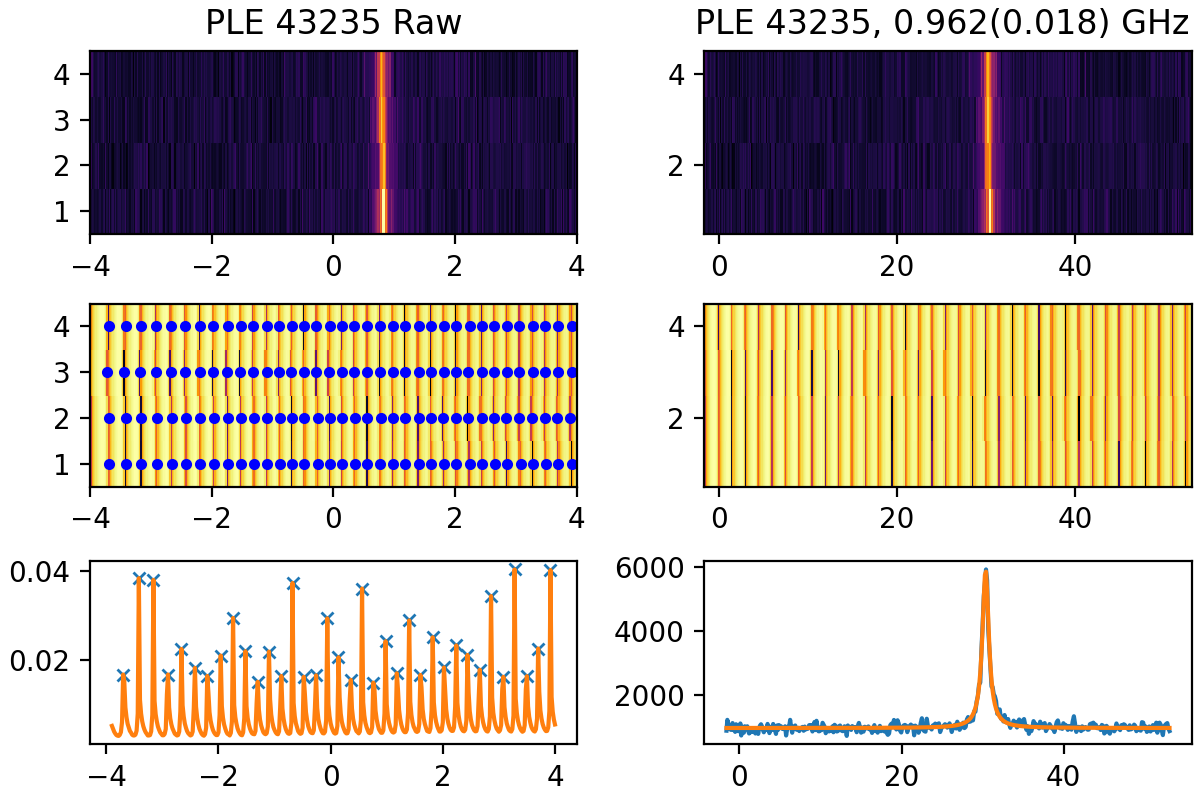

<IPython.core.display.Javascript object>


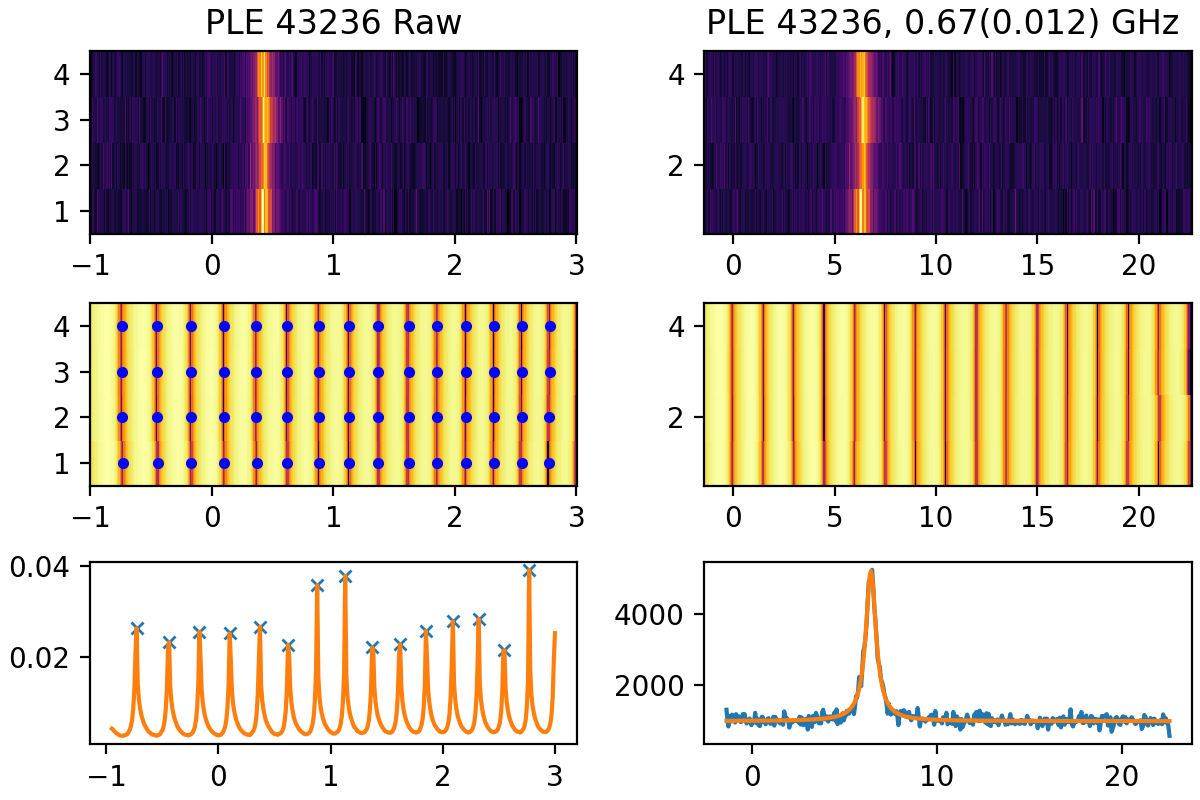

<IPython.core.display.Javascript object>


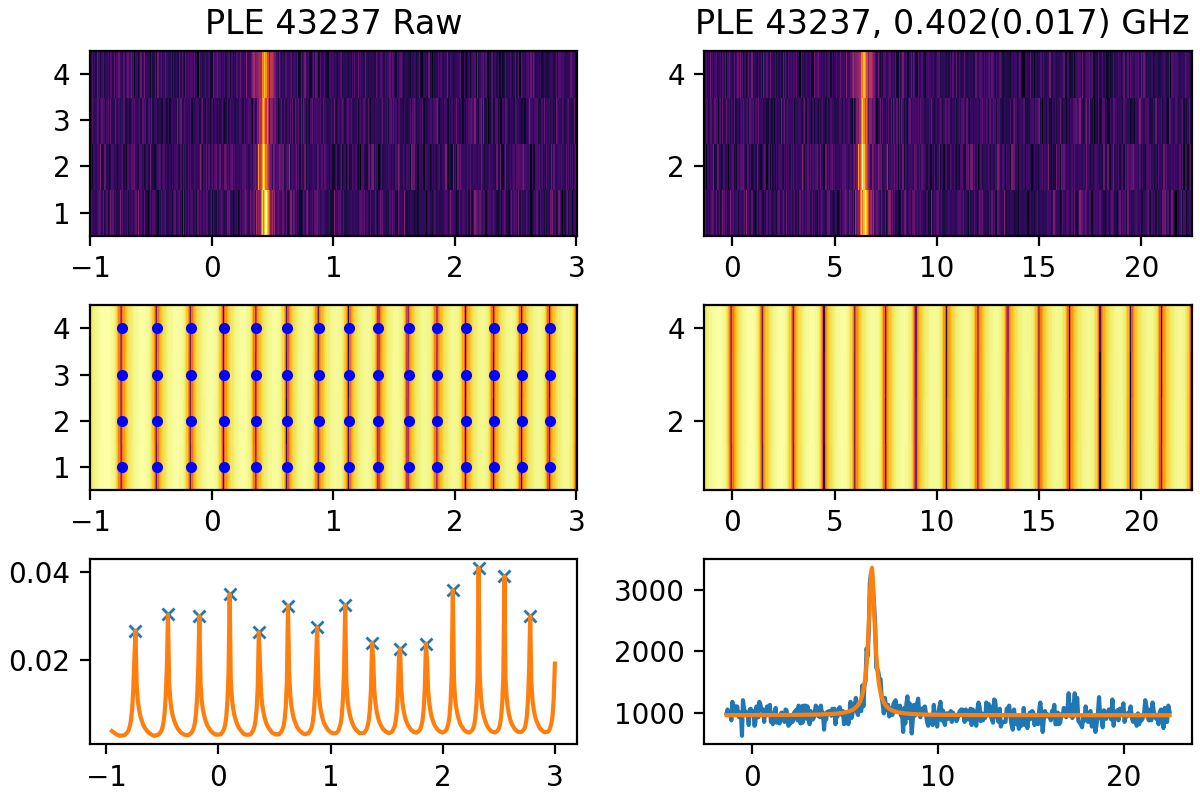

<IPython.core.display.Javascript object>


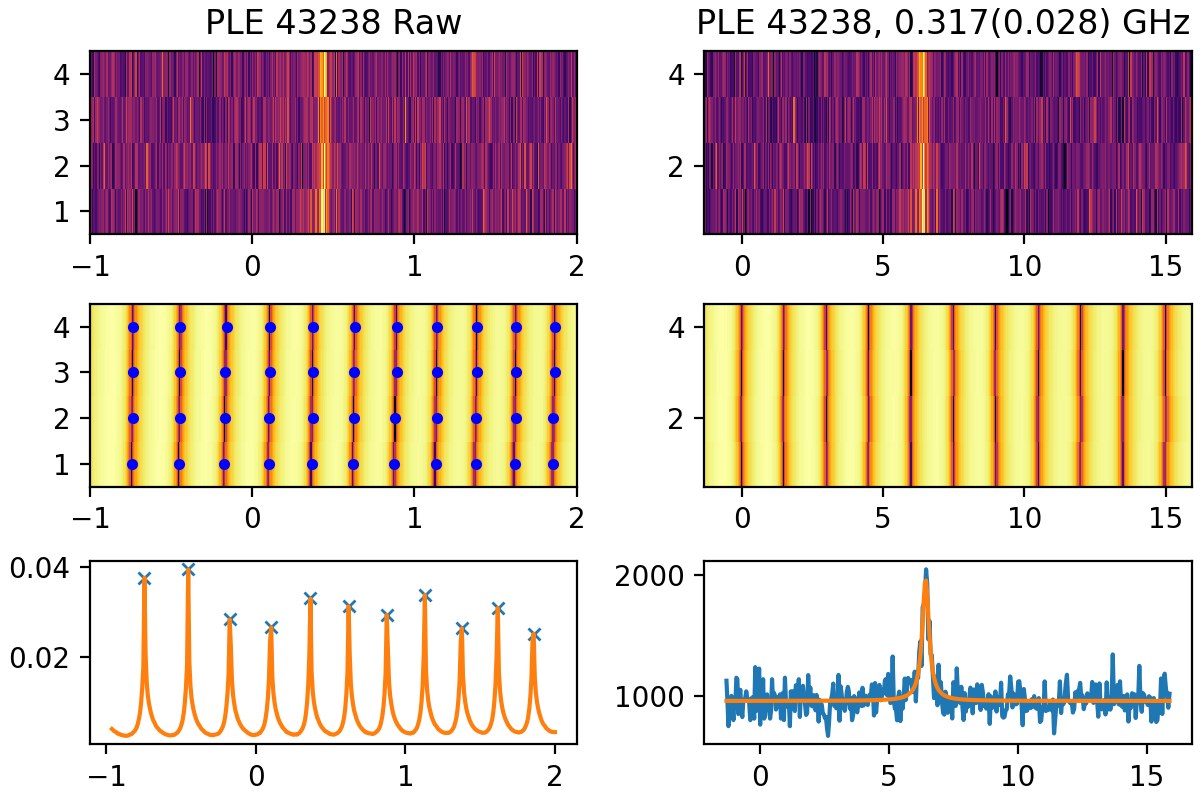

In [348]:
filenumarray = np.linspace(43232,43238,7)
VOA = np.linspace(3.0,4.2,7)
Wavelength = 952.3
datadir = '/Volumes/homes/deleonlab/data/SiV/2020-12-22 PLE on MT/PLE'
PLEprocBatch(filenumarray,datadir,VOA,options = 1)

<IPython.core.display.Javascript object>


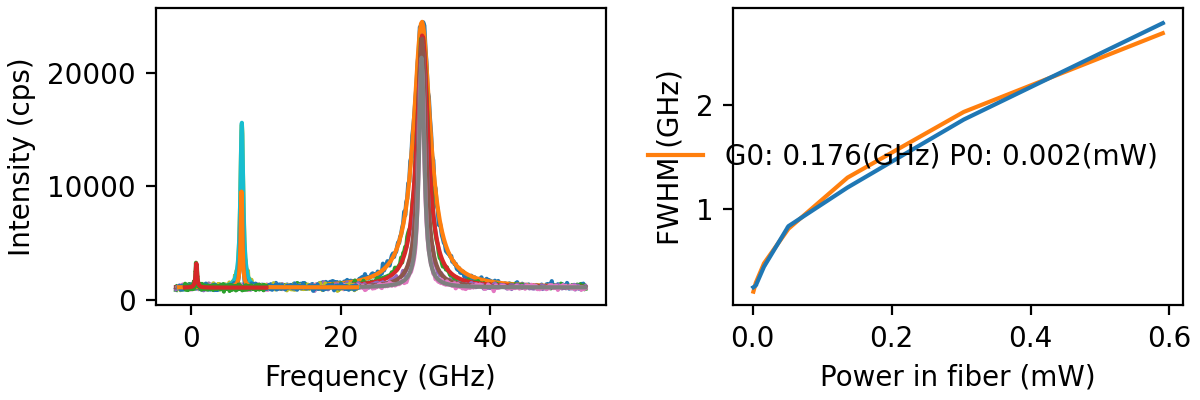

<IPython.core.display.Javascript object>


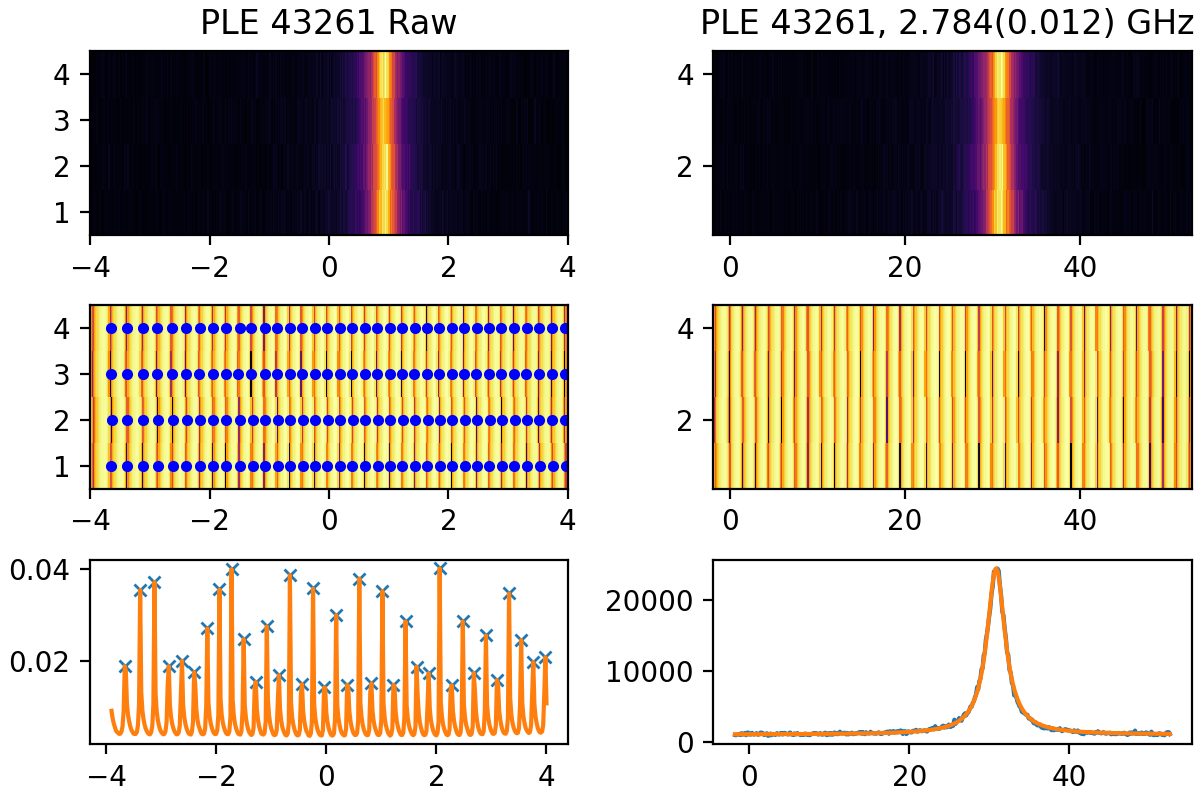

<IPython.core.display.Javascript object>


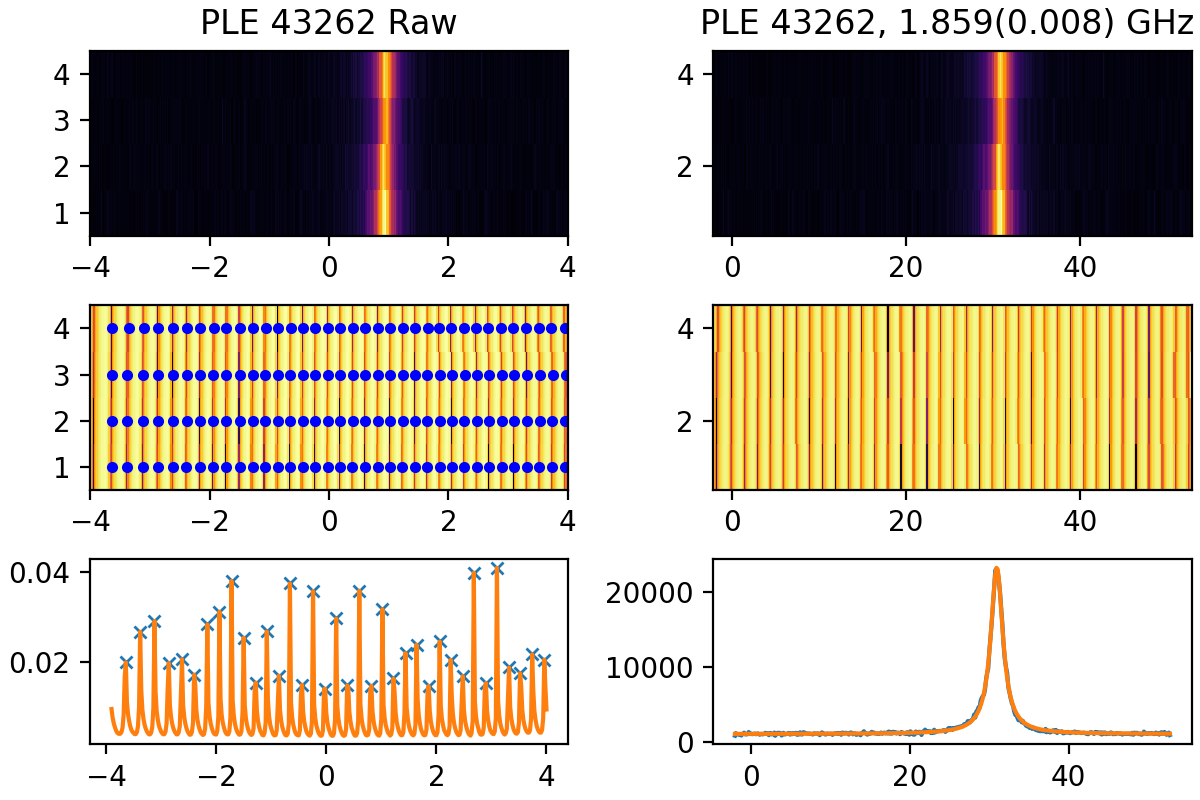

<IPython.core.display.Javascript object>


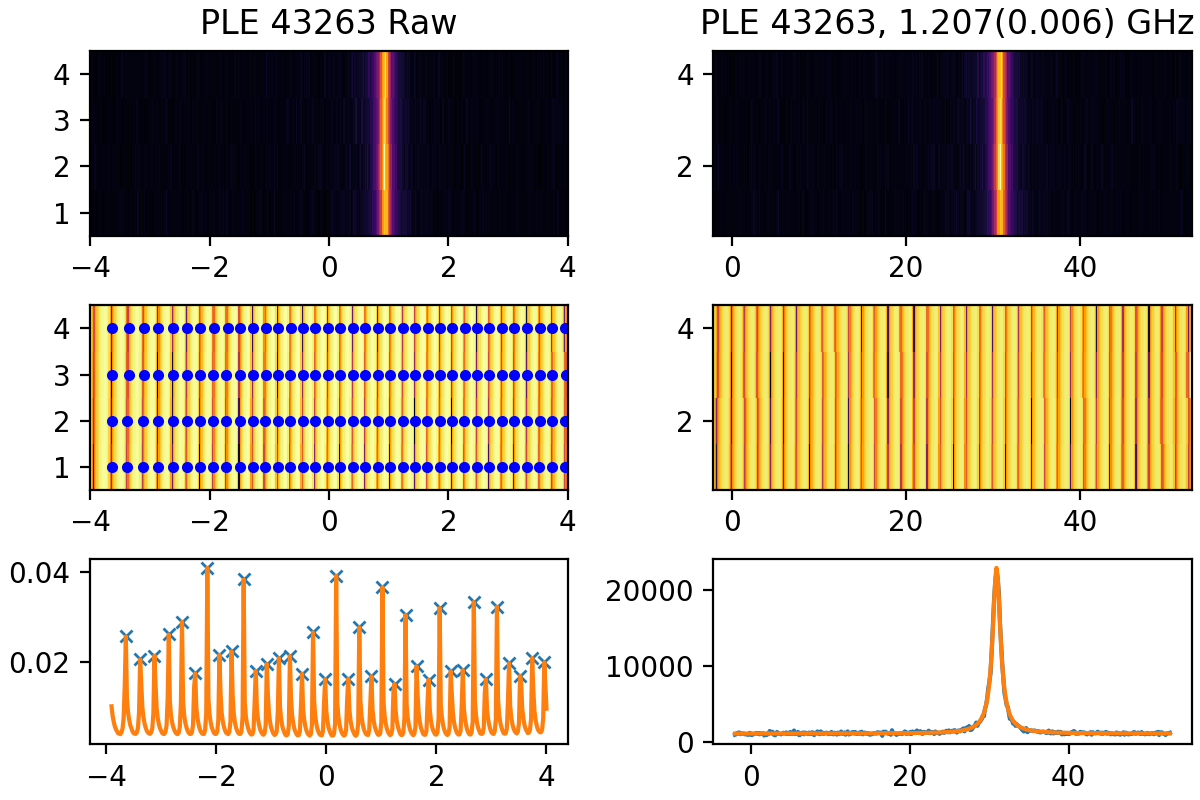

<IPython.core.display.Javascript object>


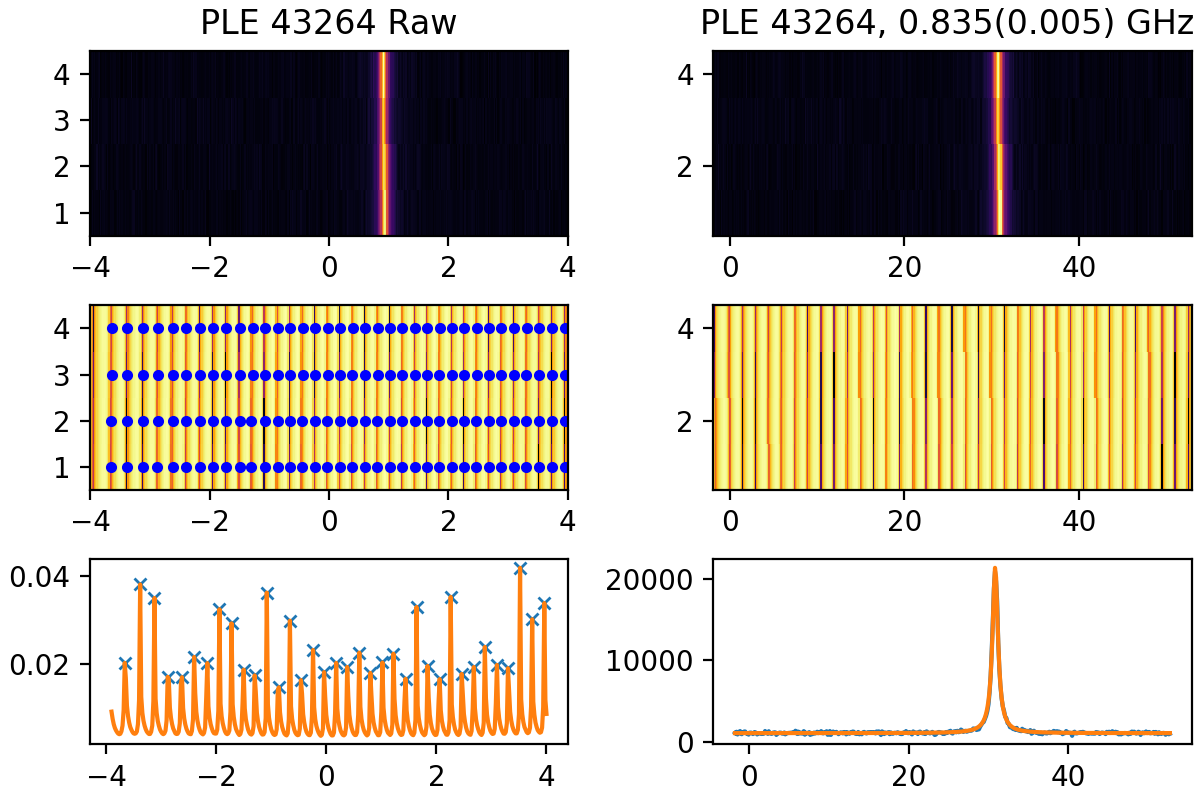

<IPython.core.display.Javascript object>


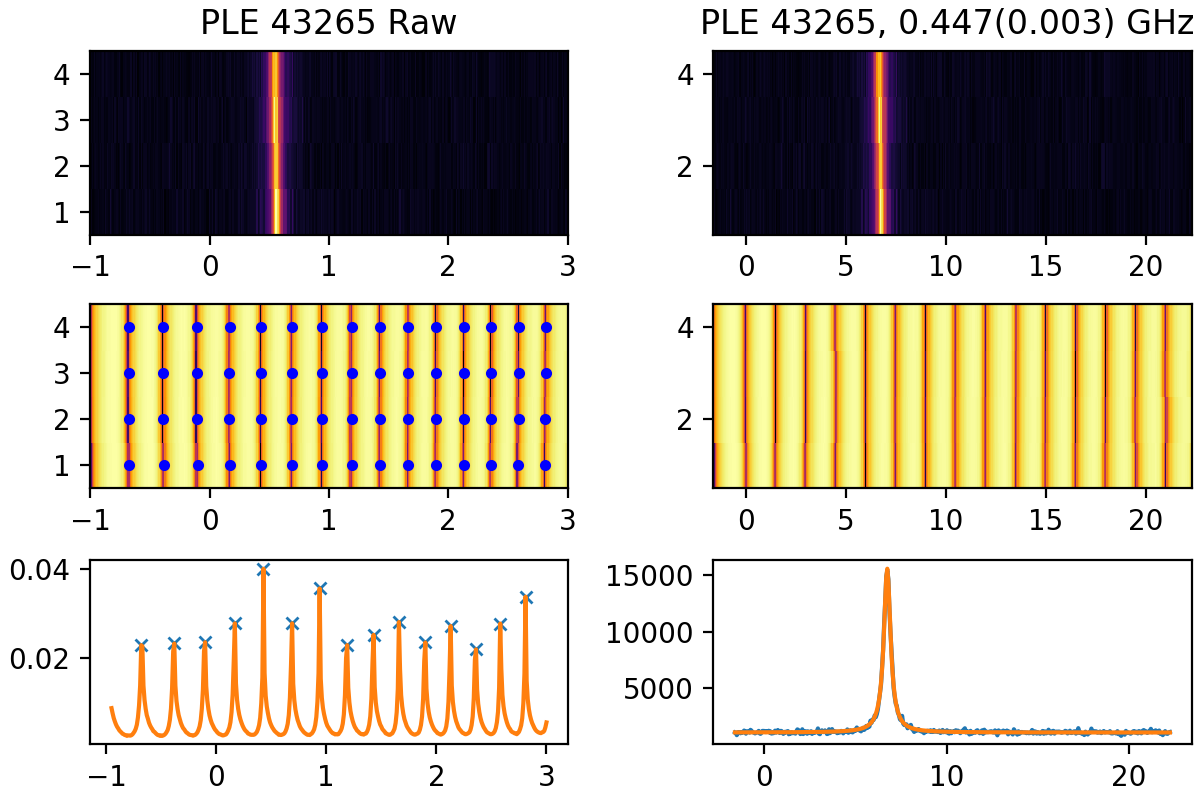

<IPython.core.display.Javascript object>


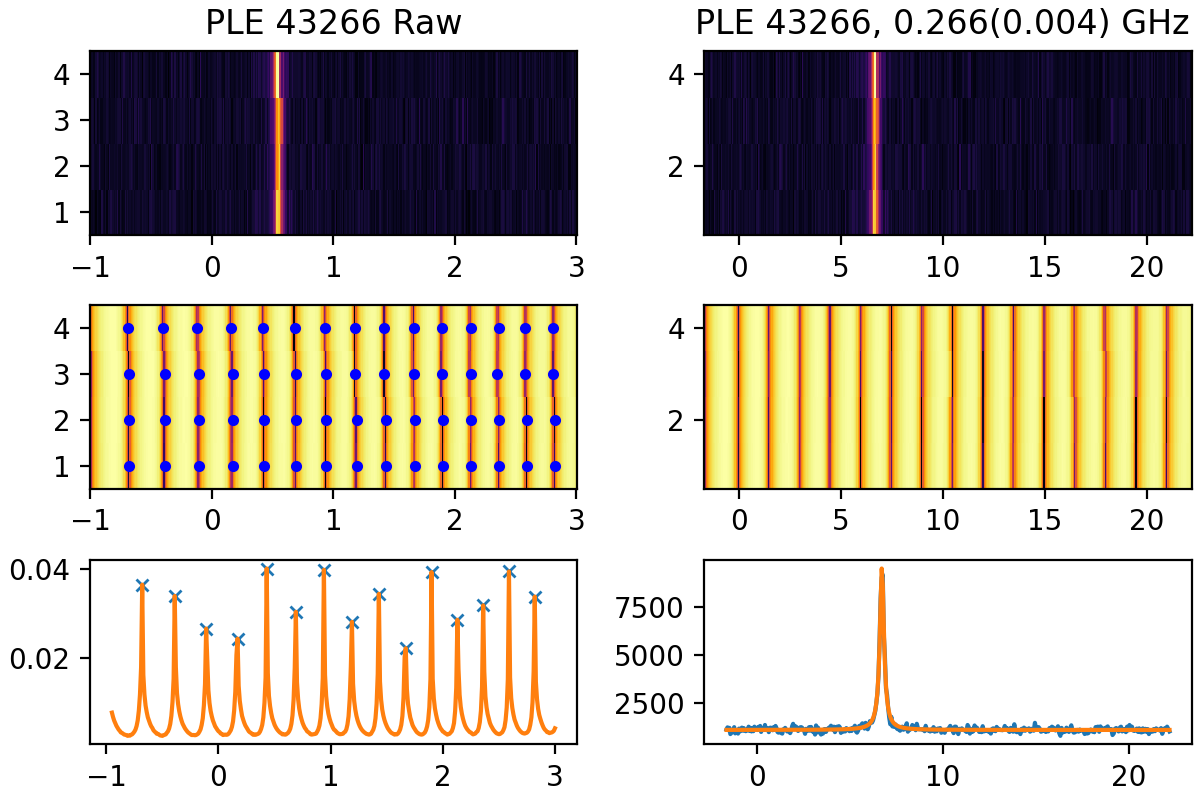

<IPython.core.display.Javascript object>


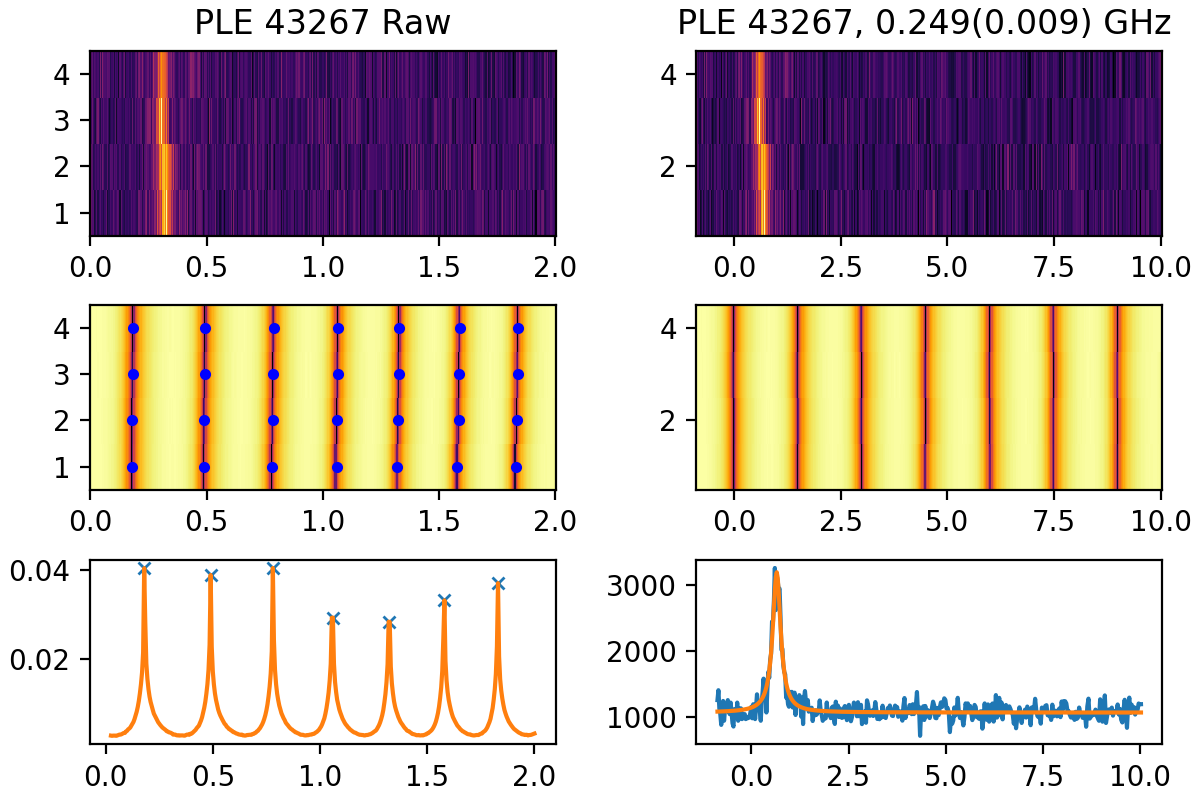

In [349]:
filenumarray = np.linspace(43261,43267,7)
VOA = np.linspace(3.0,4.2,7)
Wavelength = 952.7
datadir = '/Volumes/homes/deleonlab/data/SiV/2020-12-22 PLE on MT/PLE'
PLEprocBatch(filenumarray,datadir,VOA,options = 1)

In [355]:
filenumarray.shape

(10,)

<IPython.core.display.Javascript object>


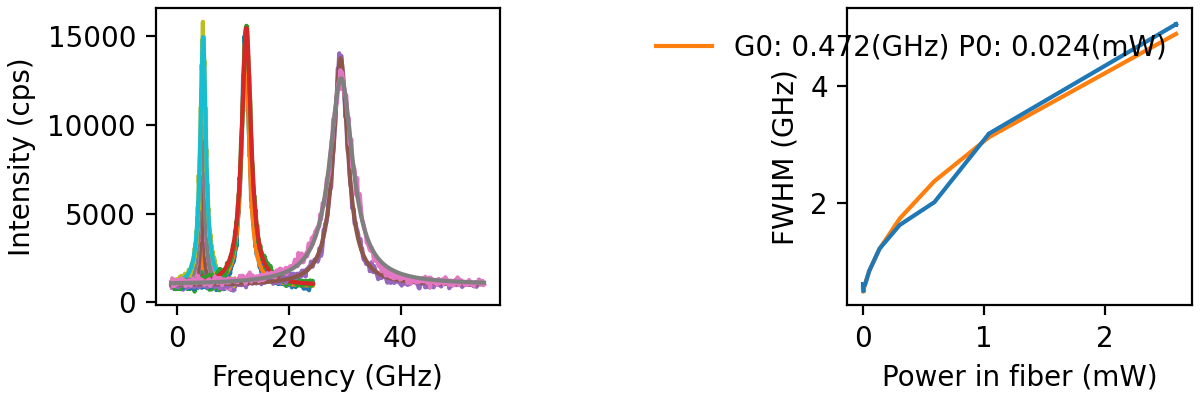

<IPython.core.display.Javascript object>


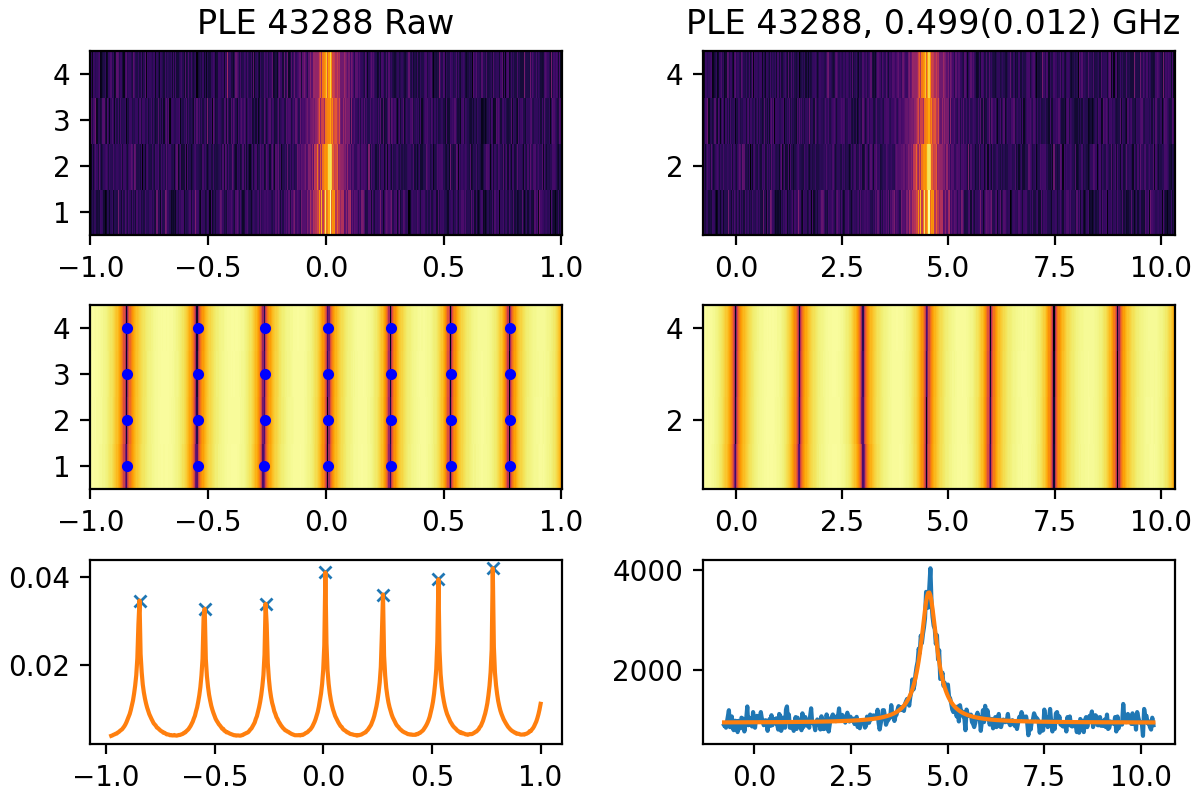

<IPython.core.display.Javascript object>


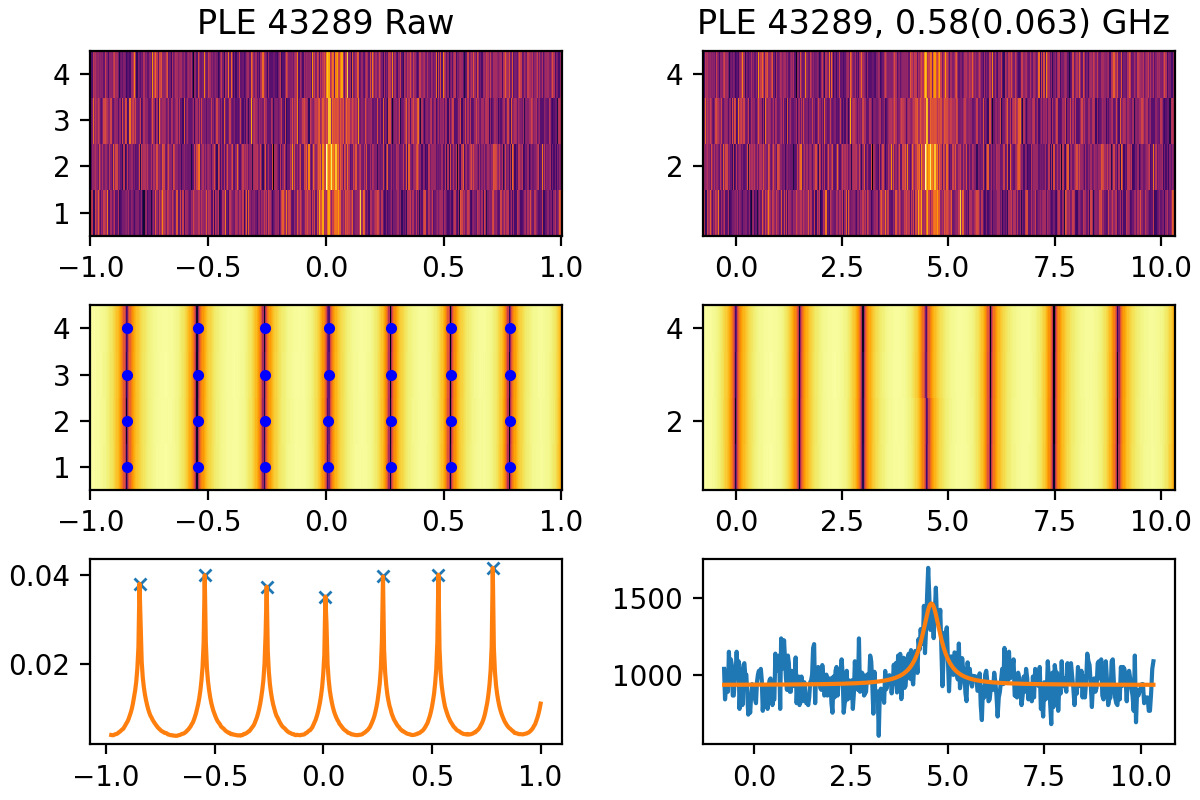

<IPython.core.display.Javascript object>


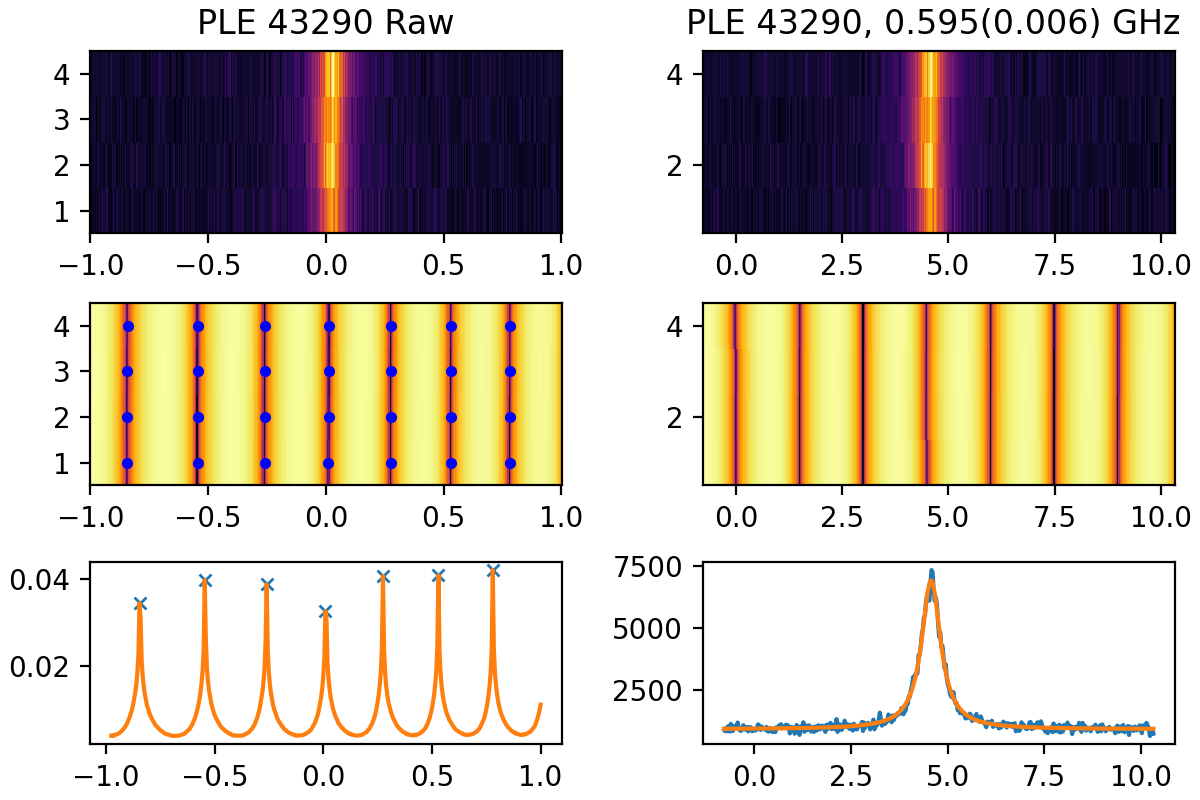

<ipython-input-358-8401f6227515>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(3,2,figsize = (6,4),constrained_layout=True)


<IPython.core.display.Javascript object>


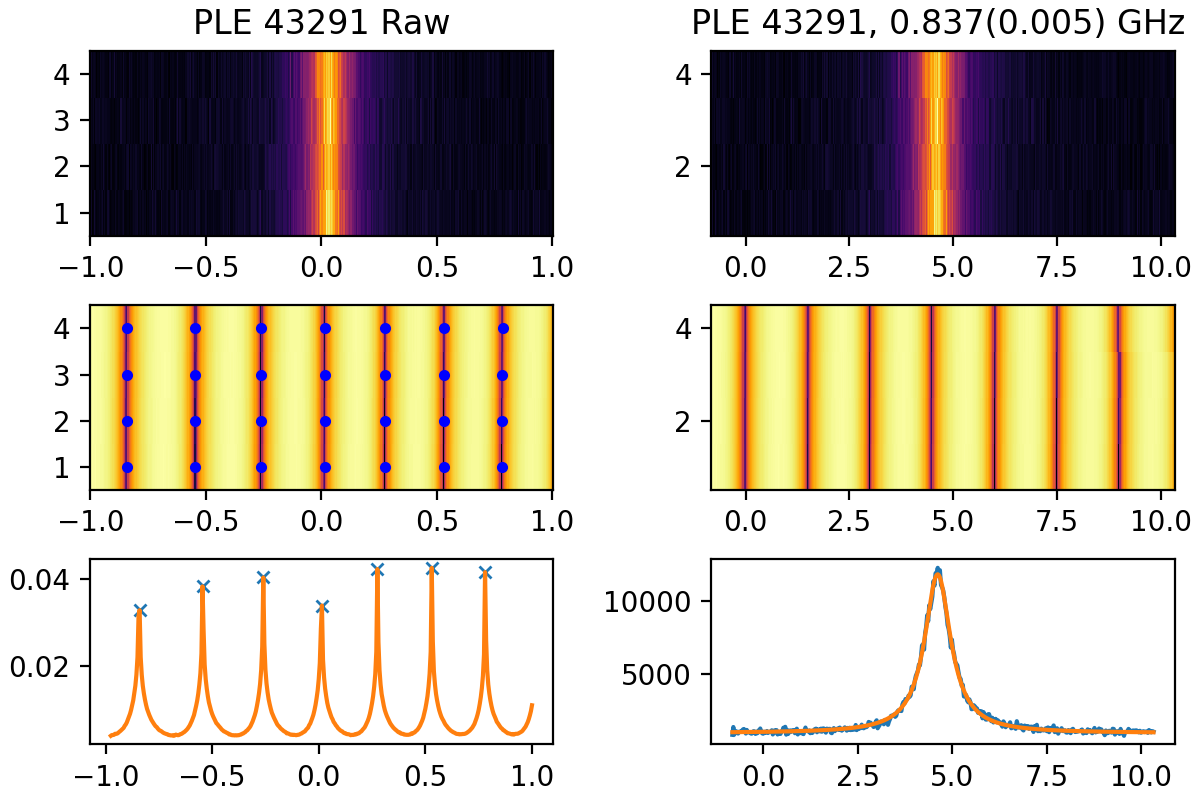

<IPython.core.display.Javascript object>


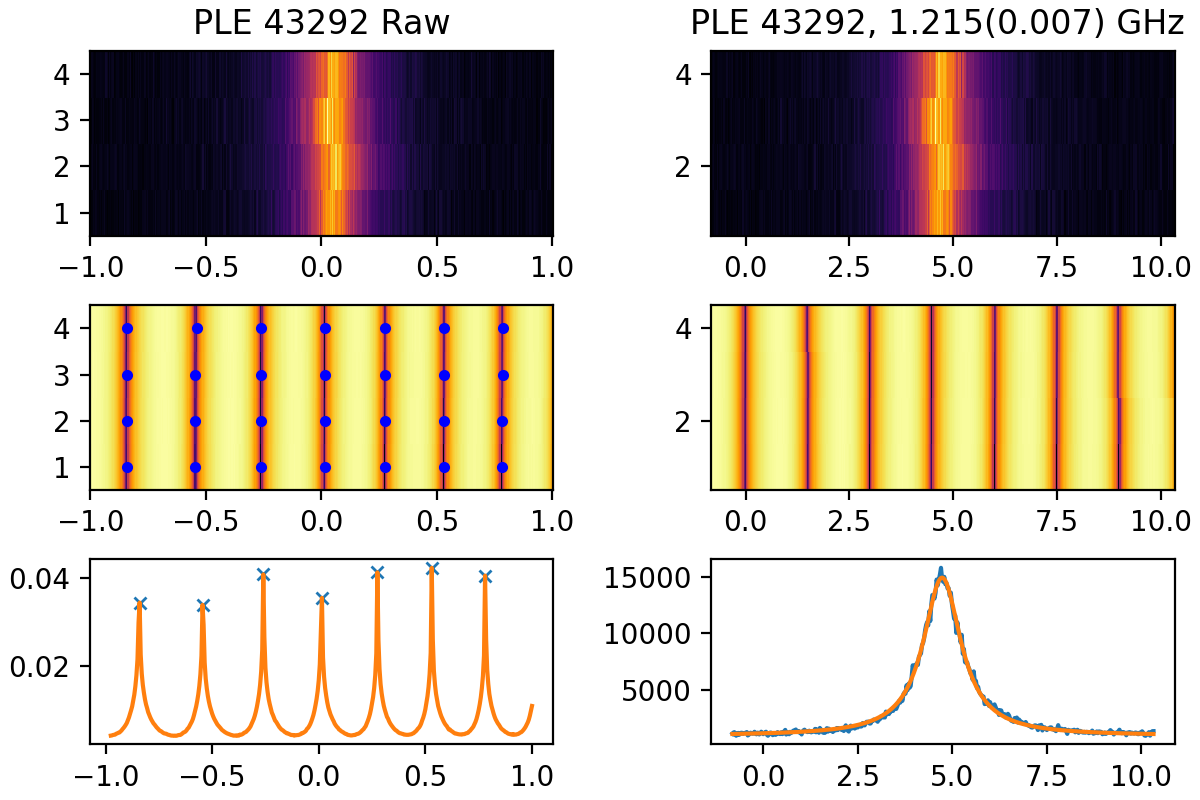

<IPython.core.display.Javascript object>


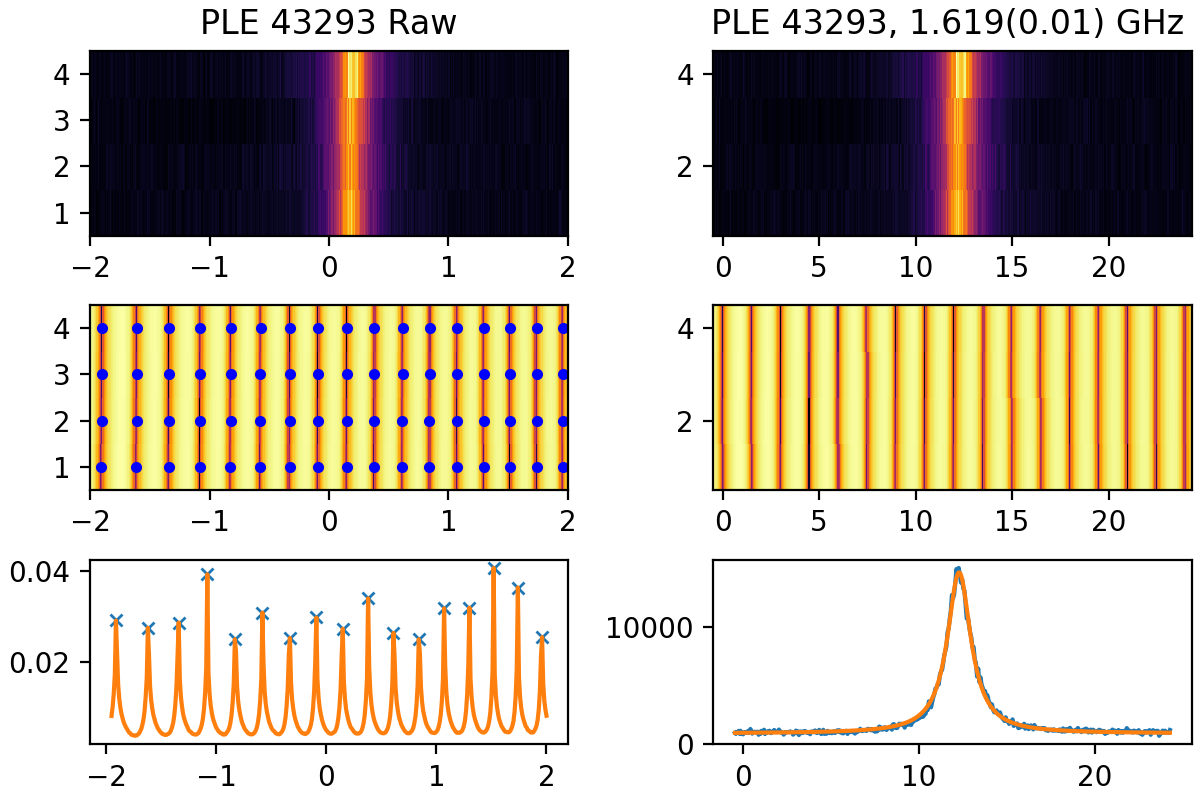

<IPython.core.display.Javascript object>


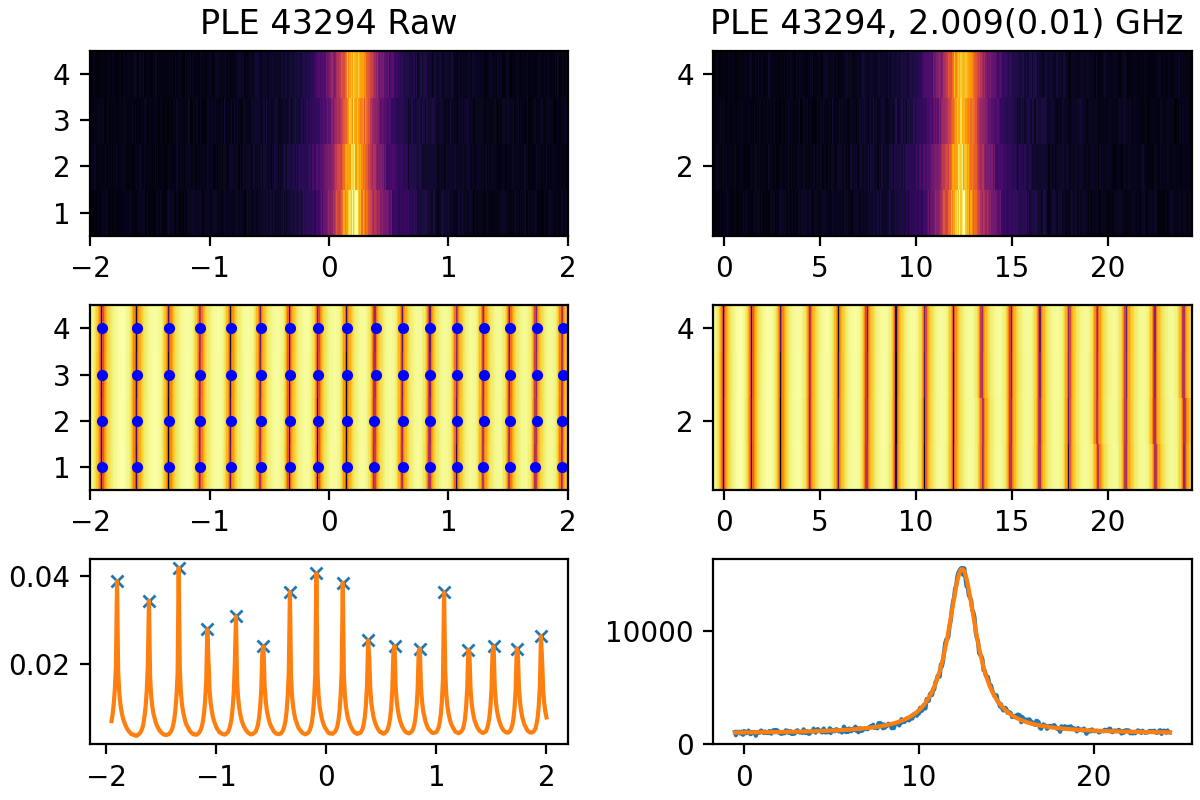

<IPython.core.display.Javascript object>


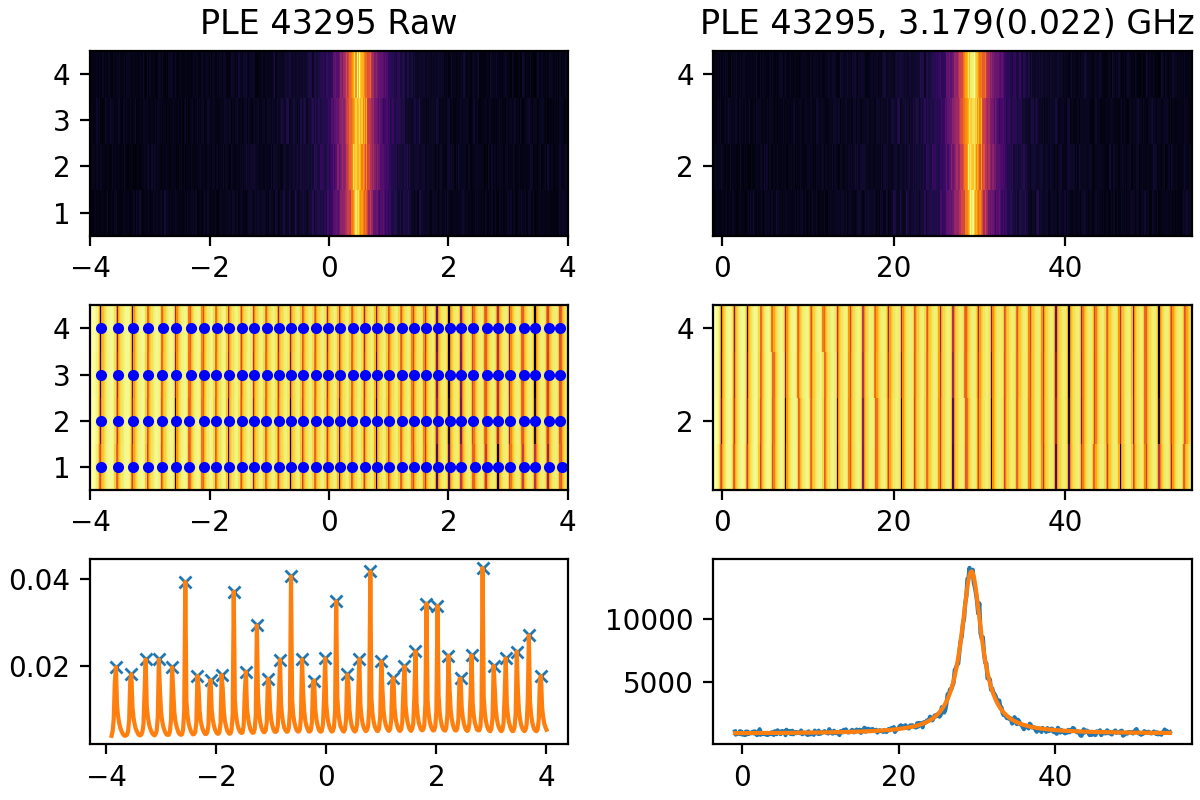

<IPython.core.display.Javascript object>


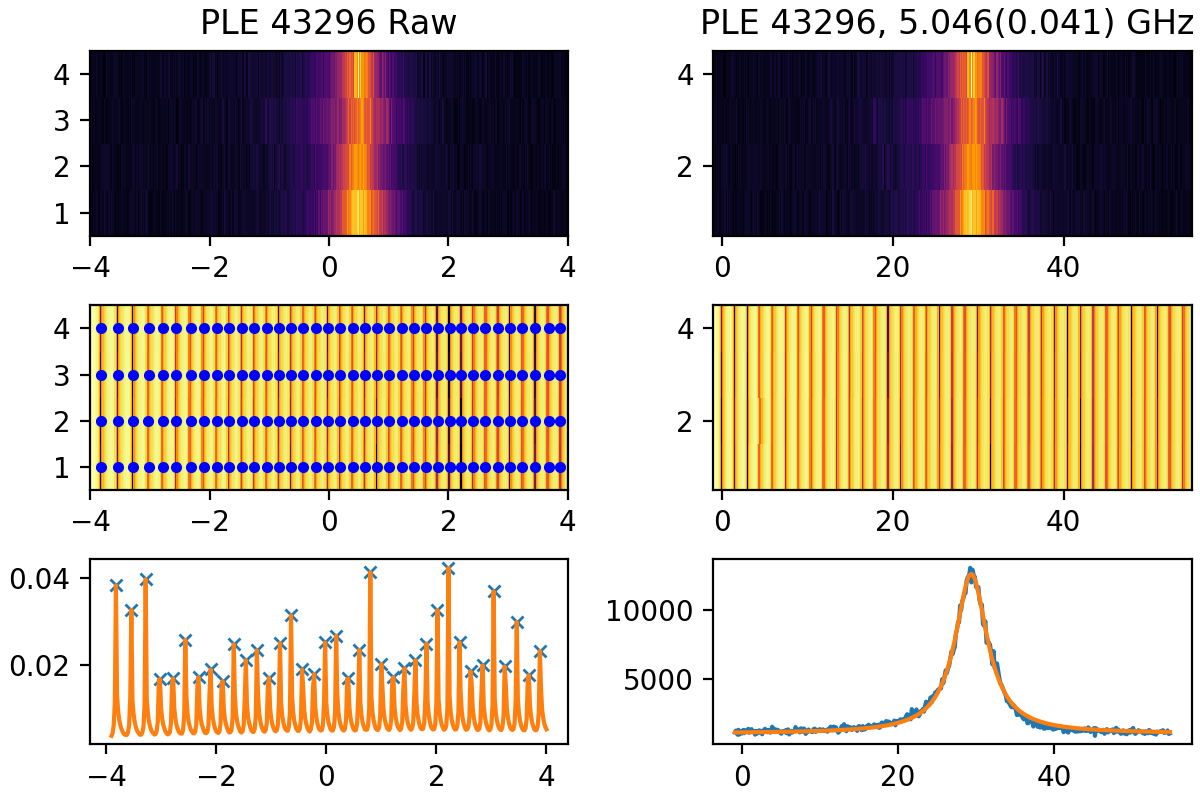

In [360]:
filenumarray = np.linspace(43288,43296,9)
VOA = np.array([4.0,4.2,3.8,3.6,3.4,3.2,3.0,2.8,2.4])
Wavelength = 945.6
datadir = '/Volumes/homes/deleonlab/data/SiV/2020-12-22 PLE on MT/PLE'
PLEprocBatch(filenumarray,datadir,VOA,options = 1)

<IPython.core.display.Javascript object>


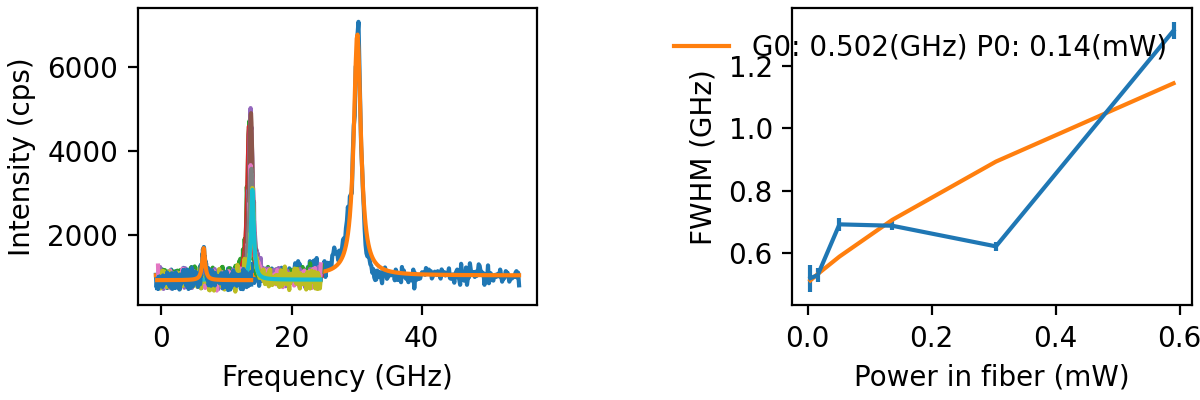

<IPython.core.display.Javascript object>


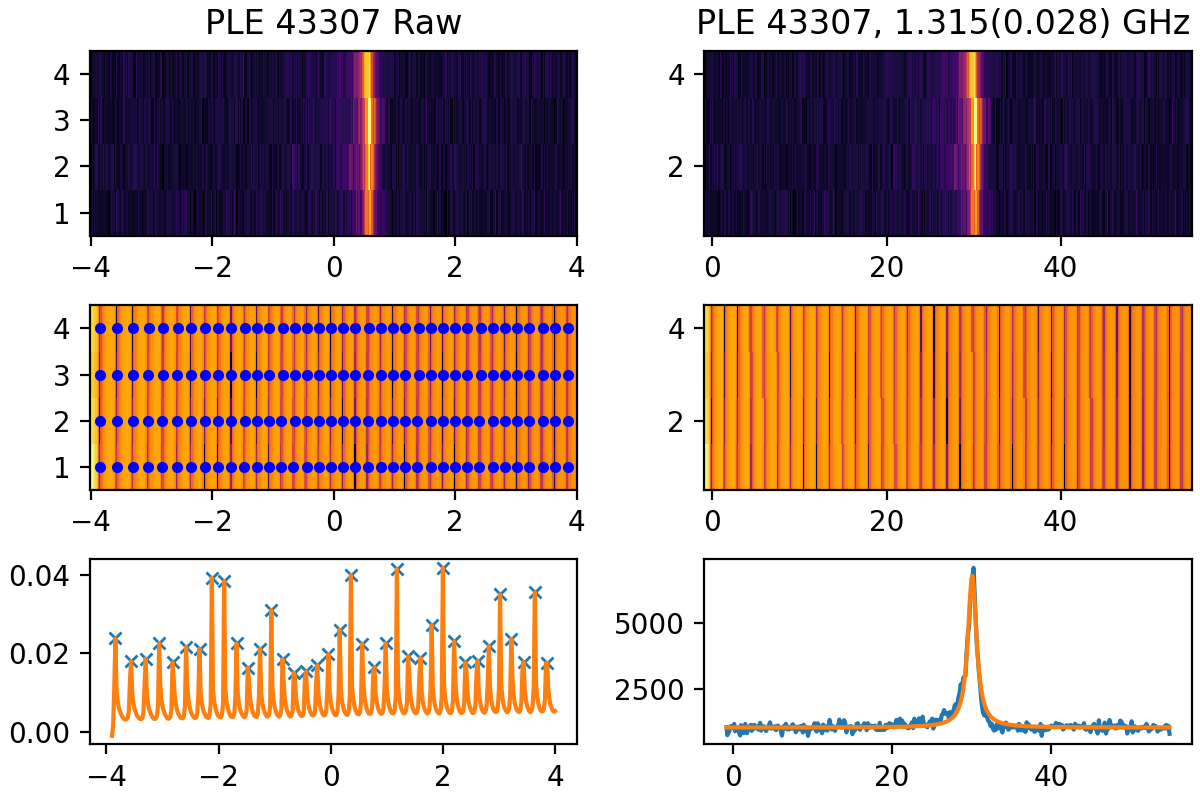

<IPython.core.display.Javascript object>


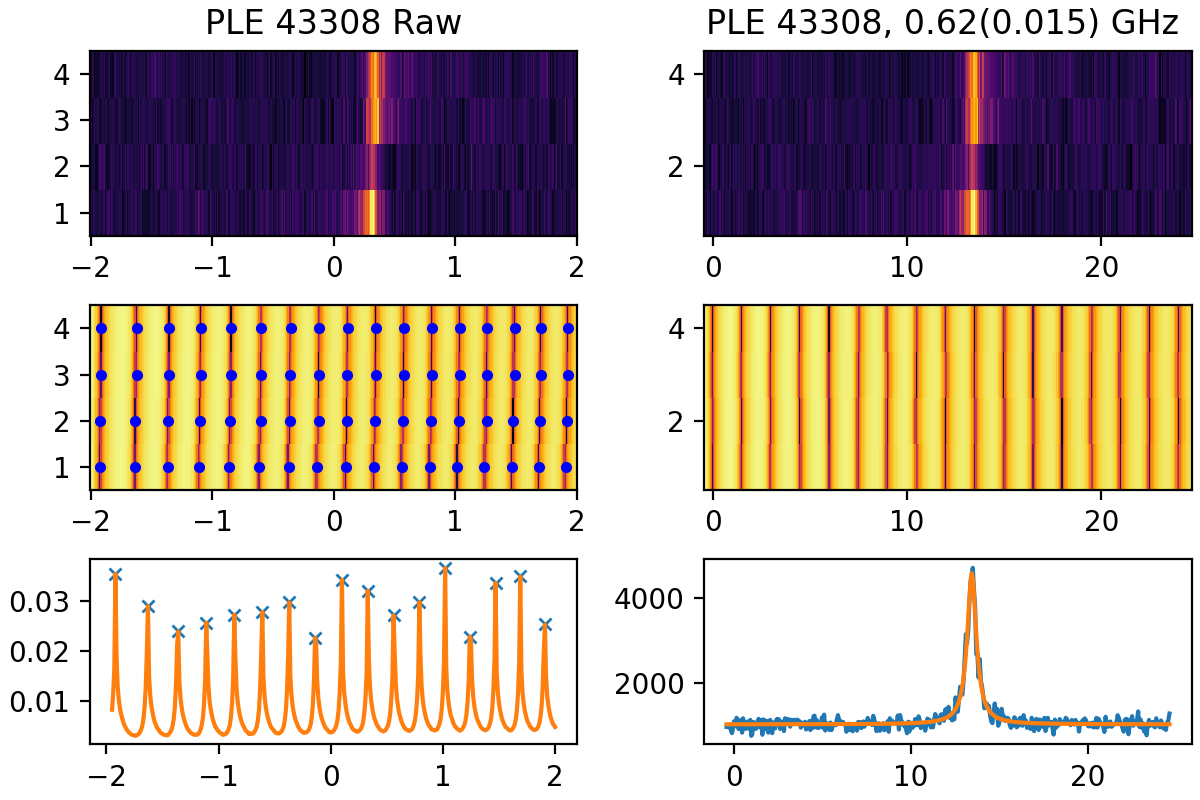

<IPython.core.display.Javascript object>


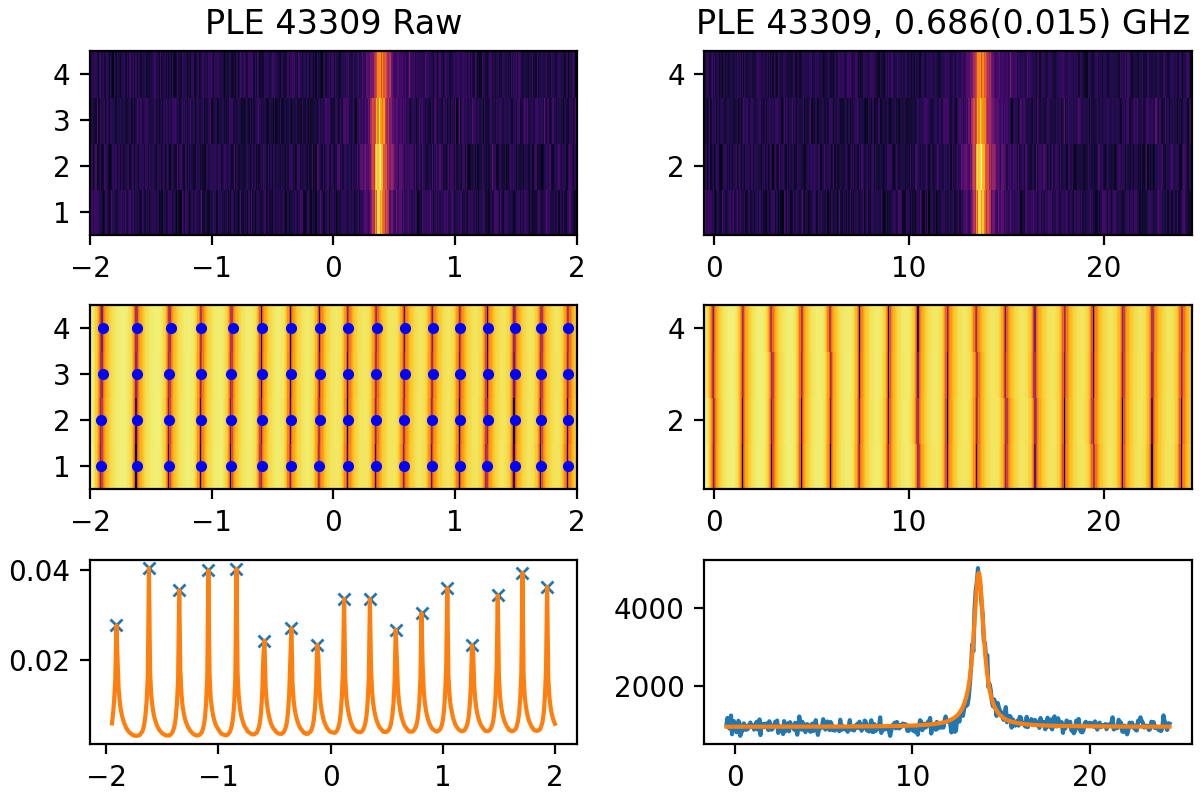

<IPython.core.display.Javascript object>


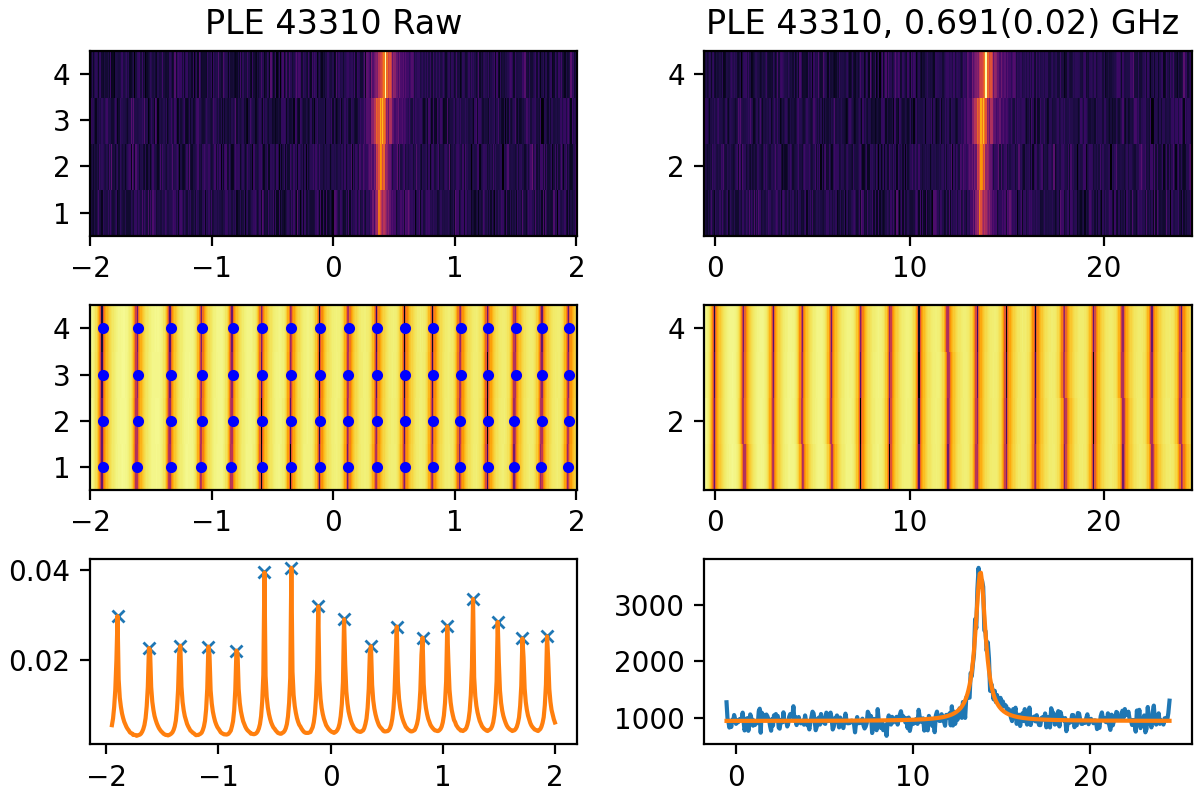

<IPython.core.display.Javascript object>


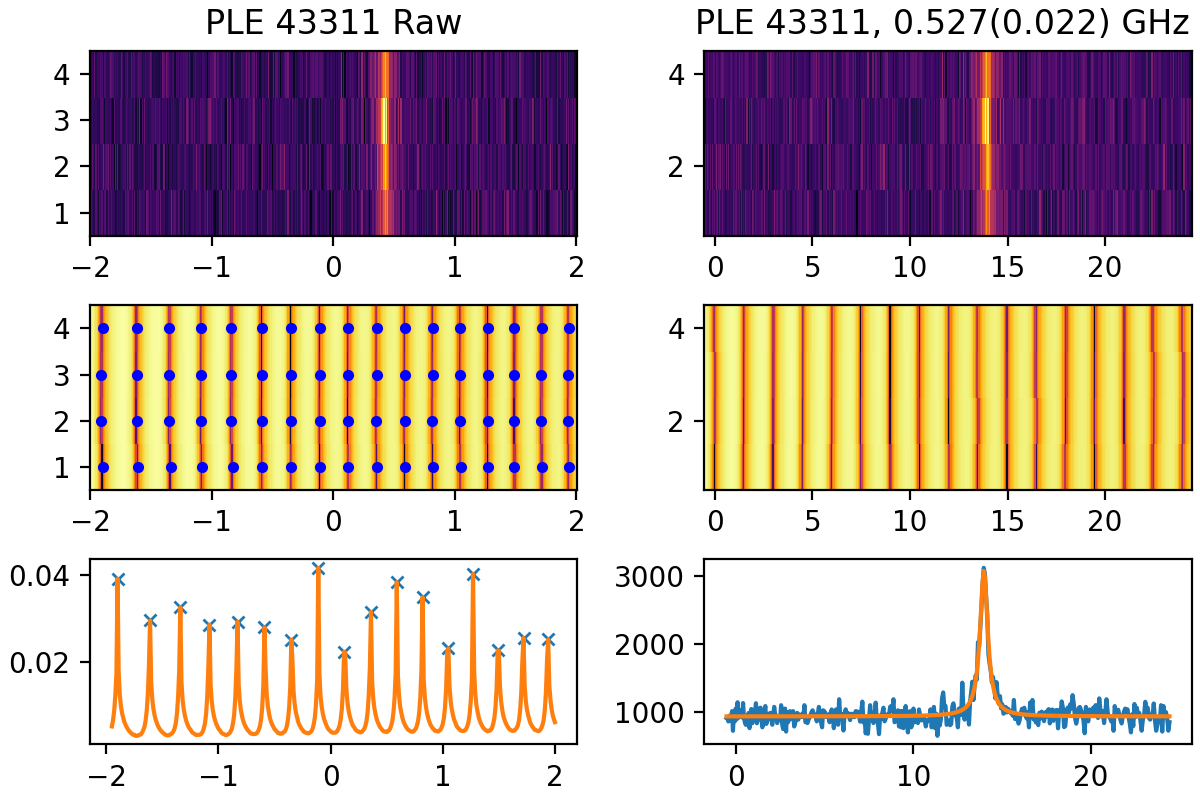

<IPython.core.display.Javascript object>


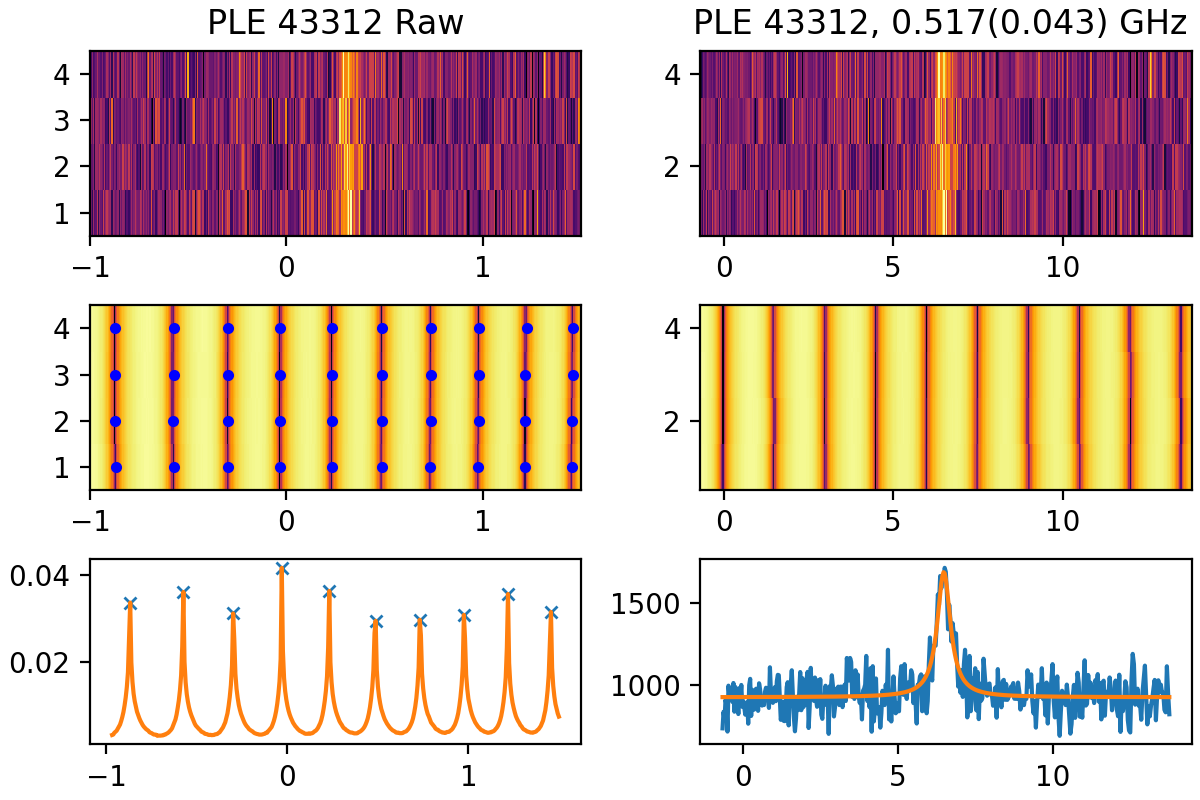

In [361]:
filenumarray = np.linspace(43307,43312,6)
VOA = np.linspace(3,4.0,6)
Wavelength = 944.5
datadir = '/Volumes/homes/deleonlab/data/SiV/2020-12-22 PLE on MT/PLE'
PLEprocBatch(filenumarray,datadir,VOA,options = 1)